In [50]:
import ast
import boto3
import time
import os
from roboflow import Roboflow
import torchvision.transforms as transforms
from PIL import Image
import torch
import pathlib
from pathlib import Path
import shutil
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import yaml
import pandas as pd

# Load environment variables from .env file
load_dotenv()

# Environment variables (set these before running the script or hard-code them here)
ROBOFLOW_KEY = os.getenv("ROBOFLOW_KEY")  # Your Roboflow API key


def download_dataset_from_roboflow(url):
    parts = url.split("/")
    ds_version = parts[-1]
    ds_project = parts[-3]
    ds_workspace = parts[-4]
    rf = Roboflow(api_key=ROBOFLOW_KEY)
    project = rf.workspace(ds_workspace).project(ds_project)
    version = project.version(ds_version)
    dataset = version.download("yolov11")
    return Path(dataset.location)

# Small drone obstacle detection

In [51]:
base_path = download_dataset_from_roboflow(
    "https://universe.roboflow.com/drone-obstacle-detection/drone-object-detection-yhpn6/dataset/73"
)

loading Roboflow workspace...
loading Roboflow project...


In [52]:
with open(base_path / "data.yaml", "r") as f:
    yaml_file = yaml.safe_load(f)

In [53]:
print(yaml_file)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 6, 'names': ['Building', 'Fence', 'House', 'Pole', 'Street Sign', 'Tree'], 'roboflow': {'workspace': 'drone-obstacle-detection', 'project': 'drone-object-detection-yhpn6', 'version': 73, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/drone-obstacle-detection/drone-object-detection-yhpn6/dataset/73'}}


In [54]:
classes = yaml_file["names"]
print("Classes in dataset:", classes)
print("Number of classes in dataset: ", len(classes))
print("Number of training images: ", len(os.listdir(base_path / "train/images")))
print("Number of testing images: ", len(os.listdir(base_path / "test/images")))
print("Number of validation images: ", len(os.listdir(base_path / "valid/images")))

Classes in dataset: ['Building', 'Fence', 'House', 'Pole', 'Street Sign', 'Tree']
Number of classes in dataset:  6
Number of training images:  441
Number of testing images:  19
Number of validation images:  40


In [55]:
def class_counts_per_split(split):
    split_path = base_path / split / "labels"
    class_counts = {}
    for label in os.listdir(split_path):
        with open(split_path / label, "r") as f:
            lines = f.read().splitlines()
        for line in lines:
            class_id = line.split()[0]
            class_id = int(class_id)
            try:
                class_counts[class_id] += 1
            except:
                class_counts[class_id] = 1

    class_count_with_name = {}
    print(f"{split} split")
    print("Class name           | count")
    print("----------------------------")
    for i, c in enumerate(classes):
        try:
            count = class_counts[i]
        except:
            count = 0
        print(f"{c:<20} | {count}")
        class_count_with_name[c] = count
    return class_count_with_name

In [56]:
train_count = class_counts_per_split("train")

train split
Class name           | count
----------------------------
Building             | 936
Fence                | 330
House                | 333
Pole                 | 618
Street Sign          | 240
Tree                 | 3453


In [57]:
test_count = class_counts_per_split("test")

test split
Class name           | count
----------------------------
Building             | 18
Fence                | 2
House                | 10
Pole                 | 15
Street Sign          | 0
Tree                 | 79


In [58]:
valid_count = class_counts_per_split("valid")

valid split
Class name           | count
----------------------------
Building             | 77
Fence                | 16
House                | 17
Pole                 | 36
Street Sign          | 9
Tree                 | 203


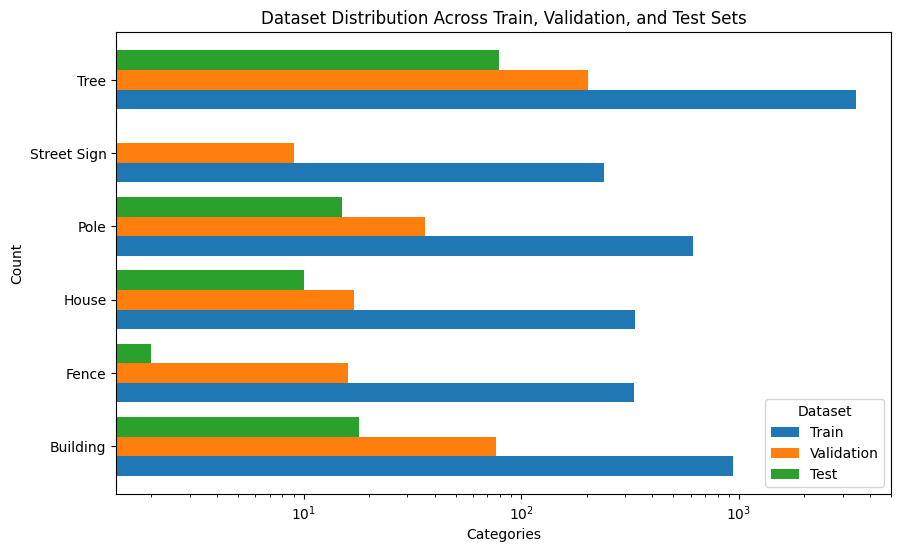

In [59]:
# Create a DataFrame
data = {"Train": train_count, "Validation": valid_count, "Test": test_count}
df = pd.DataFrame(data)

# Plotting
df.plot(kind="barh", figsize=(10, 6), width=0.8)

# Labels and title
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Dataset Distribution Across Train, Validation, and Test Sets")
plt.xscale("log")
plt.legend(title="Dataset")

plt.show()

# VisDrone Dataset

In [60]:
base_path = download_dataset_from_roboflow(
    "https://universe.roboflow.com/visdrone/visdrone-lzsy1/dataset/3"
)

loading Roboflow workspace...
loading Roboflow project...


In [61]:
with open(base_path / "data.yaml", "r") as f:
    yaml_file = yaml.safe_load(f)

In [62]:
print(yaml_file)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 12, 'names': ['Awning-tricycle', 'Bicycle', 'Bus', 'Car', 'Ignore', 'Motor', 'Others', 'Pedestrian', 'People', 'Tricycle', 'Truck', 'Van'], 'roboflow': {'workspace': 'visdrone', 'project': 'visdrone-lzsy1', 'version': 3, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/visdrone/visdrone-lzsy1/dataset/3'}}


In [63]:
classes = yaml_file["names"]
print("Classes in dataset:", classes)
print("Number of classes in dataset: ", len(classes))
print("Number of training images: ", len(os.listdir(base_path / "train/images")))
print("Number of testing images: ", len(os.listdir(base_path / "test/images")))
print("Number of validation images: ", len(os.listdir(base_path / "valid/images")))

Classes in dataset: ['Awning-tricycle', 'Bicycle', 'Bus', 'Car', 'Ignore', 'Motor', 'Others', 'Pedestrian', 'People', 'Tricycle', 'Truck', 'Van']
Number of classes in dataset:  12
Number of training images:  6469
Number of testing images:  1610
Number of validation images:  547


In [65]:
train_count = class_counts_per_split("train")

train split
Class name           | count
----------------------------
Awning-tricycle      | 2375
Bicycle              | 7874
Bus                  | 4433
Car                  | 113594
Ignore               | 6739
Motor                | 22109
Others               | 1164
Pedestrian           | 57709
People               | 20285
Tricycle             | 3358
Truck                | 10004
Van                  | 18845


In [66]:
test_count = class_counts_per_split("test")

test split
Class name           | count
----------------------------
Awning-tricycle      | 455
Bicycle              | 841
Bus                  | 1932
Car                  | 19712
Ignore               | 1529
Motor                | 4159
Others               | 180
Pedestrian           | 13711
People               | 4300
Tricycle             | 370
Truck                | 1725
Van                  | 3792


In [67]:
valid_count = class_counts_per_split("valid")

valid split
Class name           | count
----------------------------
Awning-tricycle      | 383
Bicycle              | 766
Bus                  | 208
Car                  | 10089
Ignore               | 959
Motor                | 3199
Others               | 19
Pedestrian           | 5195
People               | 3523
Tricycle             | 681
Truck                | 522
Van                  | 1343


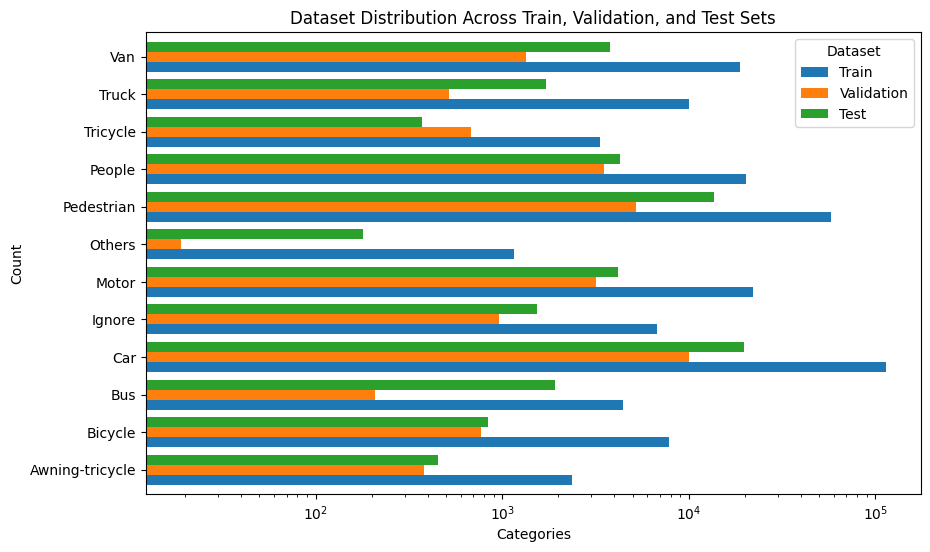

In [68]:
# Create a DataFrame
data = {"Train": train_count, "Validation": valid_count, "Test": test_count}
df = pd.DataFrame(data)

# Plotting
df.plot(kind="barh", figsize=(10, 6), width=0.8)

# Labels and title
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Dataset Distribution Across Train, Validation, and Test Sets")
plt.xscale("log")
plt.legend(title="Dataset")

plt.show()